# Visualizing mutual fund portfolio overlaps with other indices and mutual fund portfolios

We had discussed Upset charts for visualizing fund portfolio overlaps in [Mutual fund portfolio overlap in UpSet charts](https://stockviz.biz/2018/10/22/mutual-fund-portfolio-overlap-in-upset-charts/). You can use the code below to roll your own overlap analysis for the funds you care about.

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)
library(UpSetR)
library(grid)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

indices <- Indices()
mfi <- MutualFundsIndia()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

The *Franklin India Prima* fund is a mid-cap fund. We will see how the portfolio is actually setup by intersecting it with both large-cap and mid-cap index portfolios.

In [2]:
indexName1 <- "NIFTY 100" #large-cap universe
indexName2 <- "NIFTY MIDCAP 150" #mid-cap universe
schemeCode <- 100473
schemeName <- "Franklin India Prima"
portfolioDate <- as.Date("2019-05-31")

In [3]:
# grab the data
mfPortfolio <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == portfolioDate
           & (INSTRUMENT_TYPE == 'STOCK' 
              | INSTRUMENT_TYPE == 'E' 
              | INSTRUMENT_TYPE == '' 
              | is.null(INSTRUMENT_TYPE))) %>%
    select(SYMBOL, WEIGHTAGE) %>%
    arrange(desc(WEIGHTAGE)) %>%
    collect()

indexPort1 <- indices$NseConstituents() %>%
    filter(NAME == indexName1) %>%
    select(SYMBOL, CAP_WEIGHT) %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()

indexPort2 <- indices$NseConstituents() %>%
    filter(NAME == indexName2) %>%
    select(SYMBOL, CAP_WEIGHT) %>%
    arrange(desc(CAP_WEIGHT)) %>%
    collect()

mfPortfolio %>% print(n=5)
indexPort1 %>% print(n=5)
indexPort2 %>% print(n=5)

# A tibble: 63 x 2
  SYMBOL    WEIGHTAGE
  <chr>         <dbl>
1 HDFCBANK       3.56
2 RAMCOCEM       3.13
3 KOTAKBANK      2.88
4 CUB            2.87
5 KANSAINER      2.77
# … with 58 more rows
# A tibble: 100 x 2
  SYMBOL    CAP_WEIGHT
  <chr>          <dbl>
1 HDFCBANK        9.64
2 RELIANCE        8.06
3 HDFC            6.73
4 INFY            5.15
5 ICICIBANK       5.05
# … with 95 more rows
# A tibble: 150 x 2
  SYMBOL     CAP_WEIGHT
  <chr>           <dbl>
1 RBLBANK          2.98
2 FEDERALBNK       2.39
3 LICHSGFIN        1.88
4 CUB              1.78
5 NAUKRI           1.71
# … with 145 more rows


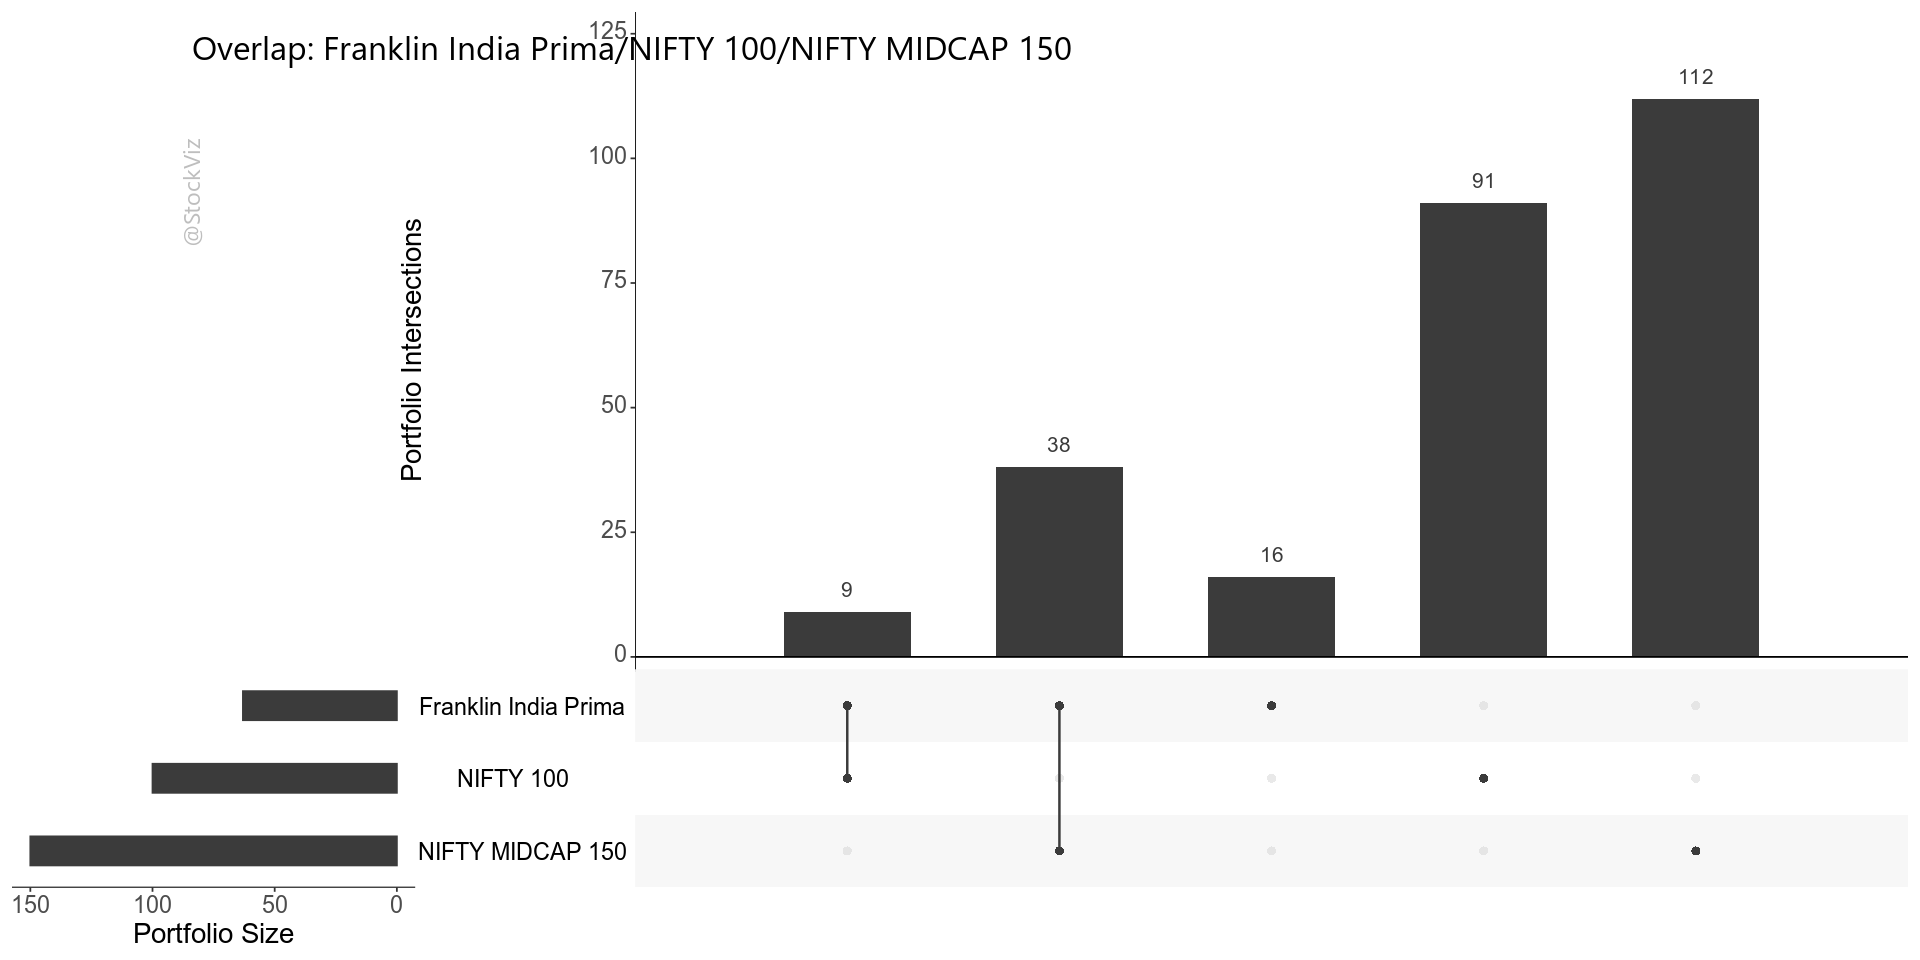

In [4]:
# create the chart

#UpSetR takes a list
listInput <- list(mfPortfolio$SYMBOL, indexPort1$SYMBOL, indexPort2$SYMBOL)
names(listInput) <- c(schemeName, indexName1, indexName2)

upset(fromList(listInput), order.by='degree', nsets=length(listInput), keep.order=T, mainbar.y.label='Portfolio Intersections', sets.x.label ='Portfolio Size', text.scale=2)
grid.text(sprintf("Overlap: %s/%s/%s", schemeName, indexName1, indexName2),x = 0.1, y=0.95, just='left', gp=gpar(fontsize=20, fontfamily='Segoe UI'))
grid.text("@StockViz",x = 0.1, y=0.8, rot=90, gp=gpar(fontsize=14, fontfamily='Segoe UI', col='grey'))

### what are the names that intersect?

In [5]:
mfPortfolio %>%
    inner_join(indexPort1) %>%
    print()

Joining, by = "SYMBOL"


# A tibble: 9 x 3
  SYMBOL    WEIGHTAGE CAP_WEIGHT
  <chr>         <dbl>      <dbl>
1 HDFCBANK      3.56       9.64 
2 KOTAKBANK     2.88       3.63 
3 BPCL          2.00       0.554
4 PETRONET      1.36       0.332
5 IDEA          1.04       0.144
6 YESBANK       1.01       0.377
7 ASHOKLEY      1.00       0.230
8 HINDALCO      0.930      0.535
9 CADILAHC      0.852      0.112


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)